In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, cross_validate
import pickle

from sklearn import set_config
set_config(transform_output='pandas')

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../data/csv/cleaned_data.csv')
df.head()

,Title,Price,Region,Bedrooms,Floor Area,Lot Area,URL,Image Link,Barangay,Town/City,Longitude,Latitude,price_per_sqm,id,Price_log
0,Brand New Single House And Lot In BF Resort Wi...,11800000,Metro Manila,4,222,96,https://www.lamudi.com.ph/brand-new-single-hou...,https://static-ph.lamudi.com/static/media/bm9u...,Talon Dos,Las Piñas,120.985214,14.438526,122916.666667,10562,16.283610
1,2 Storey Spacious Townhouse For Sale in BF Res...,8800000,Metro Manila,4,189,120,https://www.lamudi.com.ph/2-storey-spacious-to...,https://static-ph.lamudi.com/static/media/bm9u...,Talon Dos,Las Piñas,120.994250,14.432780,73333.333333,10562,15.990262
2,Reasonable price brand new single attached hou...,7200000,Metro Manila,4,128,120,https://www.lamudi.com.ph/reasonable-price-bra...,https://static-ph.lamudi.com/static/media/bm9u...,Pilar,Las Piñas,121.008940,14.424650,60000.000000,10562,15.789592
3,Spectacular PRIME LOCATION Modern 3 Storey hou...,10758000,Metro Manila,4,216,105,https://www.lamudi.com.ph/spectacular-prime-lo...,https://static-ph.lamudi.com/static/media/bm9u...,Pilar,Las Piñas,121.008014,14.417168,102457.142857,10562,16.191160
4,Brand New House And Lot In Bf Resort With Mode...,9650000,Metro Manila,4,120,85,https://www.lamudi.com.ph/brand-new-house-and-...,https://static-ph.lamudi.com/static/media/bm9u...,Talon Dos,Las Piñas,120.985214,14.438526,113529.411765,10562,16.082468


## Train-Test Split

Bedrooms - numerical, discrete to continous

In [3]:
numerical_features = ['Floor Area','Lot Area']
categorical_features = ['Town/City','Region','Bedrooms']
features = numerical_features + categorical_features
target_variable = 'Price'

In [4]:
# feature and target columns
X,y = df[features],df[target_variable]

In [5]:
X.head()

,Floor Area,Lot Area,Town/City,Region,Bedrooms
0,222,96,Las Piñas,Metro Manila,4
1,189,120,Las Piñas,Metro Manila,4
2,128,120,Las Piñas,Metro Manila,4
3,216,105,Las Piñas,Metro Manila,4
4,120,85,Las Piñas,Metro Manila,4


In [6]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=101)
X_train.shape, X_test.shape

((1152, 5), (289, 5))

## Feature Engineering
- Categorical features: Convert to binary columns by using One Hot Encoding
- Numerical features: Normalize by using StandardScaler, PolynomialFeatures

### Baseline Model

In [7]:
numerical_transformer = Pipeline(
    steps=[
        ('scaler', StandardScaler()),
        ('polynomial', PolynomialFeatures(degree=2))
    ]
)

In [8]:
categorical_transformer = Pipeline(
    steps=[
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False,drop='first'))
    ]
)

In [9]:
# Create a column transformer for categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [10]:
# Create a Pipeline that includes the preprocessor and the LinearRegression model
model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LinearRegression())
    ]
)

In [11]:
# transform price to log to make it more normally distributed
y_train_log = np.log1p(y_train)

In [12]:
# fit model
model.fit(X_train, y_train_log)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('polynomial',
                                                                   PolynomialFeatures())]),
                                                  ['Floor Area', 'Lot Area']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Town/City', 'Region',
                                                   'Bedrooms'])])),
                ('classifier', LinearRegression())])

In [13]:
# training score
training_score = model.score(X_train, y_train_log)

# test score
y_test_log = np.log1p(y_test)
test_score = model.score(X_test, y_test_log)

# print r2 score - the closer to 1, the better
print('Training score: ', training_score)
print('Test score: ', test_score)

Training score:  0.8984838842540035
Test score:  0.9017470572322711


In [14]:
### Predict train ###
# Make predictions using the model
y_pred_log = model.predict(X_train)

# Transform the predictions back to the original scale
y_pred = np.exp(y_pred_log)-1

### Predict test ###
y_test_pred_log = model.predict(X_test)

# Transform the predictions back to the original scale
y_test_pred = np.exp(y_test_pred_log)-1


In [15]:
# Get mean squared log error for train and test data - the lower the better
train_mean_sq_log_error_val = np.sqrt(mean_squared_log_error(y_train, y_pred))
print("Train RMSLE: %.2f" % train_mean_sq_log_error_val)

test_mean_sq_log_error_val = np.sqrt(mean_squared_log_error(y_test, y_test_pred))
print("Test RMSLE: %.2f" % test_mean_sq_log_error_val)

Train RMSLE: 0.31
Test RMSLE: 0.31


## Cross validation
Provide a more accurate assessment of how well a model generalizes to new data. \
It helps in detecting issues like overfitting (when a model performs well on the training data but poorly on new data) and provides a more realistic estimate of the model's performance.

In [17]:
y_log = np.log(y)
cv = cross_validate(model, X, y_log,
                    cv=5,
                    scoring='r2',
                    return_train_score=True
)
# convert the dictionary of lists into a DataFrame
cv = pd.DataFrame(cv)
print(cv.mean())

fit_time       0.073300
score_time     0.018125
test_score     0.856746
train_score    0.901660
dtype: float64


## Grid Search CV

**Define Models**

In [21]:
m_lasso = Lasso(random_state=42)
m_ridge = Ridge(random_state=42)
m_rf = RandomForestRegressor(random_state=42)
m_lr = LinearRegression()

In [18]:
# Create a column transformer for categorical and numerical features
preprocessor_rf = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [28]:
# Create a function to get the parameters set in each model
def get_parameters(model):
    # Common parameters for all models
    common_params = {
        'preprocessor__num__polynomial__degree': [1, 2, 3, 4],
        'preprocessor__num__polynomial__interaction_only': [False, True]
    }
    match model:
        case 'lasso':
            return {
                **common_params,
                'classifier__alpha' : [1.,0.001,0.1,0.01,0.05,10],
                'classifier__max_iter' : [1_000,500,100,10],
                'classifier' : [m_lasso]
            }
        case 'ridge':
            return {
                **common_params,
                'classifier__alpha' : [1.,0.001,0.1,0.01,0.05,10],
                'classifier__max_iter' : [1_000,500,100,10],
                'classifier' : [m_ridge]
            }
        case 'random_forest':
            return{
                **common_params,
                'classifier__max_depth' : [5,10],
                'classifier__n_estimators' : [5,10,20,50,100],
                'classifier' : [m_rf]
            }
        case 'linear_regression':
            return {
                **common_params,
                'classifier' : [m_lr]
            }
        case default:
            return {
                **common_params
            }

In [29]:
model_names = ['lasso', 'ridge', 'random_forest', 'linear_regression']
param_list = [get_parameters(model) for model in model_names]

In [30]:
gscv = GridSearchCV(
    estimator=model,
    param_grid=param_list,
    scoring='r2',
    cv=5, 
    n_jobs=-1,
    verbose=1
)

**Grid-search cross validation**

In [31]:
import time
# initial time
ti = time.time()

# grid-search cross-validation
gscv.fit(X_train,y_train_log)

# final time 
tf = time.time()

# time taken
print(f"time taken: {round(tf-ti,2)} sec")

Fitting 5 folds for each of 472 candidates, totalling 2360 fits


/Users/nadine/anaconda3/envs/final_project/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.485e-01, tolerance: 8.648e-02
  model = cd_fast.enet_coordinate_descent(
/Users/nadine/anaconda3/envs/final_project/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.073e-01, tolerance: 8.727e-02
  model = cd_fast.enet_coordinate_descent(
/Users/nadine/anaconda3/envs/final_project/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

time taken: 84.01 sec


**Cross validation results**

In [32]:
def get_cv_results(cv_results):
    # list of columns to show
    column_list = ['param_classifier',
                   'param_preprocessor__num__polynomial__degree',
                   'param_preprocessor__num__polynomial__interaction_only',
                   'param_classifier__alpha',
                   'param_classifier__max_iter',
                   'param_classifier__max_depth',
                   'param_classifier__n_estimators',
                   'mean_test_score',
                   'std_test_score',
                   'rank_test_score'
                  ]

    # create result dataframe
    result_df = pd.DataFrame(cv_results)[column_list]

    # rename columns
    result_df.rename(
        columns=lambda name: name.split('__')[-1],inplace=True
    )

    # order by rank
    result_df.sort_values(
        by='rank_test_score', ascending=True, inplace=True, ignore_index=True
    )
    return result_df

In [33]:
df_gscv_result = get_cv_results(gscv.cv_results_)
df_gscv_result.head(50)

,param_classifier,degree,interaction_only,alpha,max_iter,max_depth,n_estimators,mean_test_score,std_test_score,rank_test_score
0,"RandomForestRegressor(max_depth=10, random_sta...",4,True,NaN,NaN,10,100,0.900954,0.012143,1
1,"RandomForestRegressor(max_depth=10, random_sta...",3,True,NaN,NaN,10,100,0.900954,0.012143,1
2,"RandomForestRegressor(max_depth=10, random_sta...",2,True,NaN,NaN,10,100,0.900954,0.012143,1
3,"RandomForestRegressor(max_depth=10, random_sta...",1,False,NaN,NaN,10,100,0.900536,0.013731,4
4,"RandomForestRegressor(max_depth=10, random_sta...",1,True,NaN,NaN,10,100,0.900536,0.013731,4
5,"RandomForestRegressor(max_depth=10, random_sta...",2,False,NaN,NaN,10,100,0.900432,0.012120,6
6,"RandomForestRegressor(max_depth=10, random_sta...",1,False,NaN,NaN,10,50,0.899458,0.013664,7
7,"RandomForestRegressor(max_depth=10, random_sta...",1,True,NaN,NaN,10,50,0.899458,0.013664,7
8,"RandomForestRegressor(max_depth=10, random_sta...",2,False,NaN,NaN,10,50,0.898767,0.012042,9
9,"RandomForestRegressor(max_depth=10, random_sta...",4,True,NaN,NaN,10,50,0.898685,0.012401,10


**Best hyperparameters and model**

In [34]:
gscv.best_params_

{'classifier': RandomForestRegressor(max_depth=10, random_state=42),
 'classifier__max_depth': 10,
 'classifier__n_estimators': 100,
 'preprocessor__num__polynomial__degree': 2,
 'preprocessor__num__polynomial__interaction_only': True}

In [35]:
best_model = gscv.best_estimator_
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('polynomial',
                                                                   PolynomialFeatures(interaction_only=True))]),
                                                  ['Floor Area', 'Lot Area']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Town/City', 'Region',
                                                   'Bedrooms'])])),
                ('classifier',
                 RandomForestRegressor(max_depth=10, random_state=42))])

**Build model**

In [36]:
best_model.fit(X_train,y_train_log)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('polynomial',
                                                                   PolynomialFeatures(interaction_only=True))]),
                                                  ['Floor Area', 'Lot Area']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Town/City', 'Region',
                                                   'Bedrooms'])])),
                ('classifier',
                 RandomForestRegressor(max_depth=10, random_state=42))])

In [37]:
# training score
training_score = best_model.score(X_train,y_train_log)

# test score
test_score = best_model.score(X_test,y_test_log)

print(f'Train score: {round(training_score,6)}')
print(f'Test score : {round(test_score,6)}')

Train score: 0.971831
Test score : 0.91136


Result shows that this might be overfitting, so I try to use other models and check results

## Selected model

When I used the best_estimator_ with RandomForestRegressor with n_estimators=100 and max_depth=10 \ 
it gave me a train score of 0.97 and test score of 0.91 \
and cross_validation train mean score of 0.97 and test mean score of 0.87. \
And for this I feel like the gap is too big.

In [49]:
# Create a Pipeline that includes the preprocessor and the LinearRegression model
sel_model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        # ('classifier', Ridge(alpha=0.1, max_iter=10,random_state=42))
        # ('classifier', Lasso(alpha=0.01, max_iter=1000,random_state=42))
        # ('classifier', LinearRegression())
        ('classifier', RandomForestRegressor(n_estimators=100, max_depth=10,random_state=42))
    ]
)

In [50]:
# fit model
sel_model.fit(X_train, y_train_log)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('polynomial',
                                                                   PolynomialFeatures())]),
                                                  ['Floor Area', 'Lot Area']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Town/City', 'Region',
                                                   'Bedrooms'])])),
                ('classifier',
                 RandomForestRegressor(max_depth=10, random_state=42))])

In [51]:
# training score
training_score = sel_model.score(X_train, y_train_log)

# test score
test_score = sel_model.score(X_test, y_test_log)

# print r2 score - the closer to 1, the better
print('Training score: ', training_score)
print('Test score: ', test_score)

Training score:  0.9720436745939842
Test score:  0.9103098465219354


In [52]:
cv = cross_validate(sel_model, X, y_log,
                    cv=5,
                    scoring='r2',
                    return_train_score=True
)
# convert the dictionary of lists into a DataFrame
cv = pd.DataFrame(cv)
print(cv.mean())

fit_time       0.771700
score_time     0.021711
test_score     0.877893
train_score    0.971682
dtype: float64


In [53]:
### Predict train ###
# Make predictions using the model
y_pred_log = sel_model.predict(X_train)

# Transform the predictions back to the original scale
y_pred = np.exp(y_pred_log)-1

### Predict test ###
y_test_pred_log = sel_model.predict(X_test)

# Transform the predictions back to the original scale
y_test_pred = np.exp(y_test_pred_log)-1

In [54]:
# Get mean squared log error for train and test data - the lower the better
train_mean_sq_log_error_val = np.sqrt(mean_squared_log_error(y_train_log, y_pred_log))
print("Train RMSLE: %.2f" % train_mean_sq_log_error_val)

test_mean_sq_log_error_val = np.sqrt(mean_squared_log_error(y_test_log, y_test_pred_log))
print("Test RMSLE: %.2f" % test_mean_sq_log_error_val)

Train RMSLE: 0.01
Test RMSLE: 0.02


In [ ]:
# Calculate evaluation metrics
mse = mean_squared_error(y_train, y_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

rmse = mean_squared_error(y_train, y_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

mae = mean_absolute_error(y_train, y_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

r2 = r2_score(y_train, y_pred)
r2_test = r2_score(y_test, y_test_pred)
# Calculate MPE and MAPE manually
mpe = np.mean((y_train - y_pred) / y_train) * 100
mpe_test = np.mean((y_test - y_test_pred) / y_test) * 100

mape = np.mean(np.abs((y_train - y_pred) / y_train)) * 100
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

# Print the results
print(f'Mean Squared Error (MSE): {mse:.2f} , {mse_test:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}, {rmse_test:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}, {mae_test:.2f}')
print(f'R-squared (R2): {r2:.2f}, {r2_test:.2f}')
print(f'Mean Percentage Error (MPE): {mpe:.2f}%, {mpe_test:.2f}%')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%, {mape_test:.2f}%')

### Export model

In [55]:
# Assuming `model` is your trained model
with open('../models/rf_model.pkl', 'wb') as file:
    pickle.dump(sel_model, file)


## Plot predicted test vs actual test values

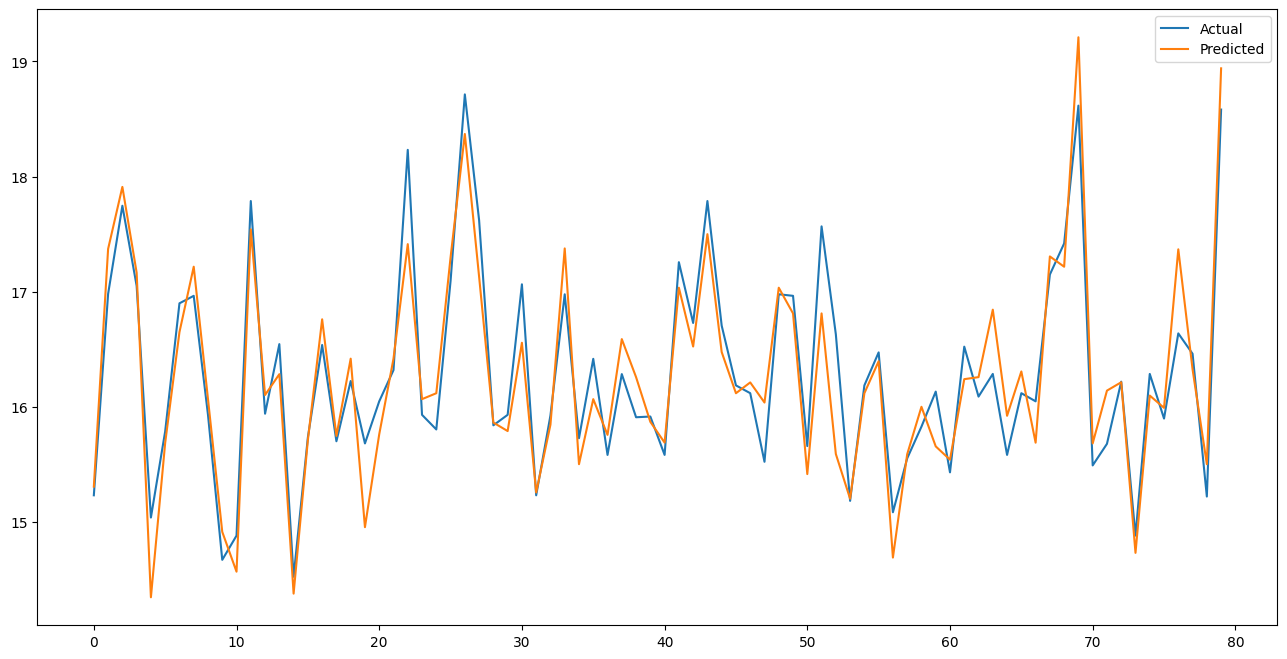

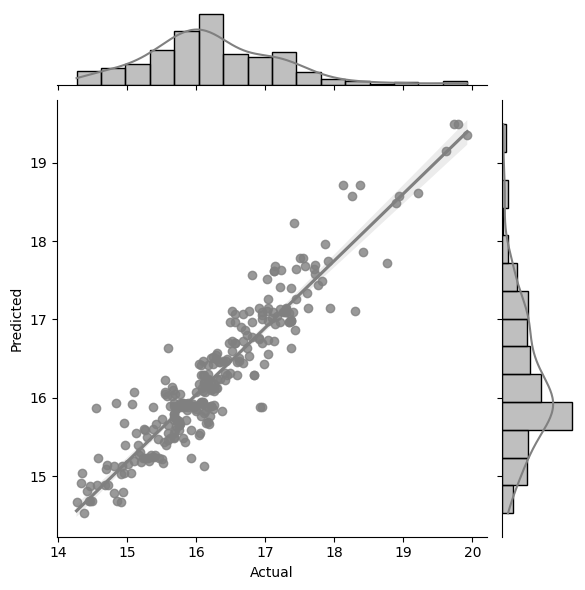

In [45]:
test_log = pd.DataFrame({'Predicted':y_test_pred_log,'Actual':y_test_log})
fig= plt.figure(figsize=(16,8))
test = test_log.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:80])
plt.legend(['Actual','Predicted'])
sns.jointplot(x='Actual',y='Predicted',data=test,kind='reg',color="grey")

In [ ]:
test_log.head()

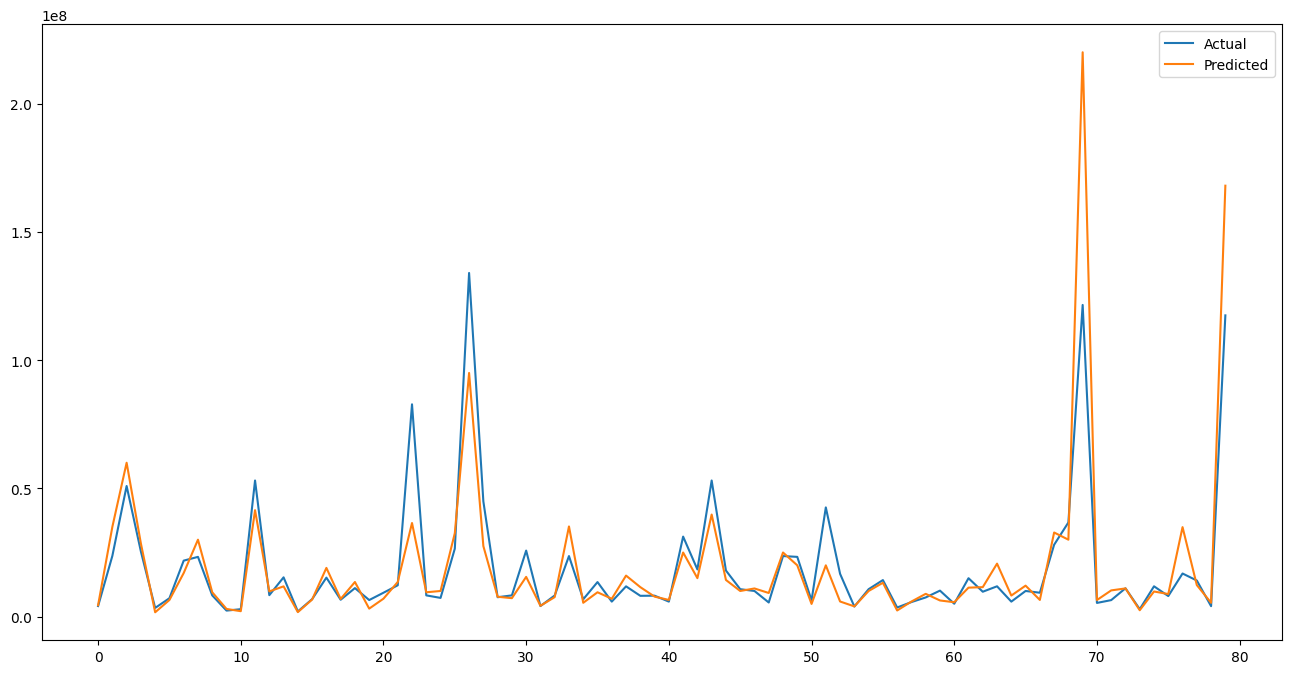

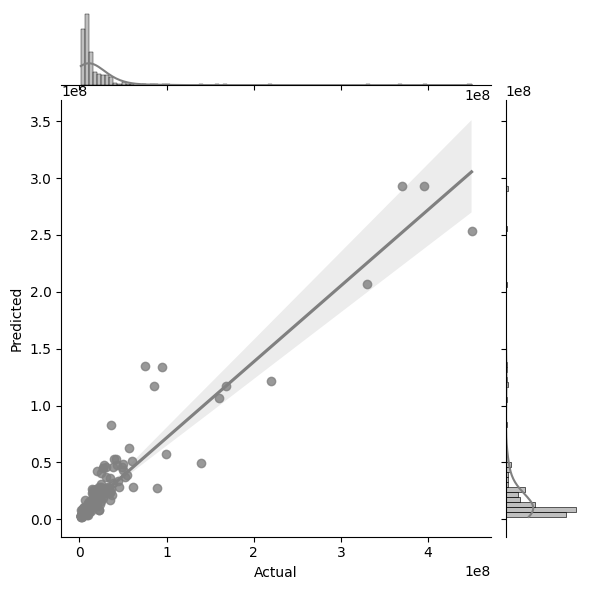

In [46]:
test = pd.DataFrame({'Predicted':y_test_pred,'Actual':y_test})
fig= plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:80])
plt.legend(['Actual','Predicted'])
sns.jointplot(x='Actual',y='Predicted',data=test,kind='reg',color="grey")

In [ ]:
test.head()

In [47]:
# import model
with open("../models/rf_model.pkl", "rb") as model_file:
    model = pickle.load(model_file)

In [48]:
# test prediction
input_features = [[130, 300, 'Antipolo', 'Rizal', 2]]
input_df = pd.DataFrame(input_features, columns=['Floor Area', 'Lot Area', 'Town/City', 'Region', 'Bedrooms'])
predicted_price_log = model.predict(input_df)
predicted_price = np.exp(predicted_price_log)-1
predicted_price

array([12884613.98072318])

In [ ]:
from forex_python.converter import CurrencyRates
c = CurrencyRates()

c.convert('EUR', 'PHP', 1)